# 01: Tracer Recording

**The Question:** Does the real 128D dead token cloud behave like our 2D toy?

The tidal toy (notebook 00) showed something surprising: tokens don't just compress toward a needle—they converge to a **single point**. A fixed-point attractor at position LR/WD along the gradient axis.

If this is real physics and not toy-artifact, we should see the same behavior in Duckling II.

**Method:**
1. Pick 100 random dead tokens as "tracers"
2. Train, recording the full 128D embeddings of tracers each step
3. At the end, compute h̄ and project everything to 2D
4. Plot traces, just like the toy

**Storage:** 100 tokens × 128 dims × 4 bytes = 51.2KB per step. 20K steps = ~1GB. Fine.

## Parameters

In [14]:
# === DUCKLING II REFERENCE PARAMETERS ===
# Do not modify unless intentionally deviating

# Architecture
VOCAB_SIZE = 8192      # 6,144 live + 2,048 dead
N_EMBD = 128
N_HEAD = 2
N_LAYER = 2
N_POSITIONS = 512
N_INNER = 512

# Training
BATCH_SIZE = 2
LEARNING_RATE = 1e-3   # CRANKED UP from 1e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0

# Reproducibility
SEED = 42

# Paths (relative to Duckling_II folder)
DUCKLING_PATH = "../Duckling_II"
DATASET_PATH = f"{DUCKLING_PATH}/tokenized_dataset"
TOKEN_MAPPING_PATH = f"{DUCKLING_PATH}/token_mapping.json"

# === EXPERIMENT PARAMETERS ===
NUM_TRACERS = 100          # How many dead tokens to track
TRAINING_STEPS = 20_000    # Total steps
RECORD_EVERY = 1           # Record every N steps (1 = every step)

## Imports & Setup

In [15]:
import json
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_callback import TrainerCallback

set_seed(SEED)

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Seed: {SEED}")

Device: mps
Seed: 42


## Load Data

In [16]:
# Load tokenized dataset
dataset = load_from_disk(DATASET_PATH)
print(f"✓ Dataset: {len(dataset):,} sequences of {N_POSITIONS} tokens")

# Load token mapping
with open(TOKEN_MAPPING_PATH, "r") as f:
    token_mapping = json.load(f)

LIVE_TOKENS = token_mapping["live_tokens"]
DEAD_TOKENS = token_mapping["dead_tokens"]
dead_token_ids = list(range(LIVE_TOKENS, VOCAB_SIZE))

print(f"✓ Vocabulary: {VOCAB_SIZE:,} total ({LIVE_TOKENS:,} live, {DEAD_TOKENS:,} dead)")

# Data collator
class CausalLMCollator:
    def __call__(self, examples):
        input_ids = torch.tensor([ex["input_ids"] for ex in examples], dtype=torch.long)
        return {"input_ids": input_ids, "labels": input_ids.clone()}

collator = CausalLMCollator()

✓ Dataset: 921,519 sequences of 512 tokens
✓ Vocabulary: 8,192 total (6,144 live, 2,048 dead)


## Select Tracers

Pick 100 random dead token IDs. These are the ones we'll track through training.

In [17]:
# Pick random tracer tokens
np.random.seed(SEED)
tracer_ids = np.random.choice(dead_token_ids, size=NUM_TRACERS, replace=False)
tracer_ids = sorted(tracer_ids)  # Sort for reproducibility

print(f"✓ Selected {NUM_TRACERS} tracer tokens")
print(f"  First 5: {tracer_ids[:5]}")
print(f"  Last 5: {tracer_ids[-5:]}")

✓ Selected 100 tracer tokens
  First 5: [np.int64(6173), np.int64(6200), np.int64(6209), np.int64(6213), np.int64(6214)]
  Last 5: [np.int64(8081), np.int64(8088), np.int64(8119), np.int64(8142), np.int64(8146)]


## Create Model

In [18]:
config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_embd=N_EMBD,
    n_head=N_HEAD,
    n_layer=N_LAYER,
    n_positions=N_POSITIONS,
    n_inner=N_INNER,
    activation_function='gelu',
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0,
    layer_norm_epsilon=1e-5,
    initializer_range=0.02,
    use_cache=False,
)

model = GPT2LMHeadModel(config)
n_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model: {n_params:,} parameters")

✓ Model: 1,510,912 parameters


## Training Run

One pass. Record tracer embeddings (full 128D) at each step. Silent logging.

In [19]:
class TracerRecorder(TrainerCallback):
    """Record full 128D embeddings of tracer tokens during training."""
    def __init__(self, tracer_ids, record_every=1):
        self.tracer_ids = tracer_ids
        self.record_every = record_every
        self.embeddings = []  # List of (N_TRACERS, 128) arrays
        self.steps = []
    
    def on_step_end(self, args, state, control, model=None, **kwargs):
        if state.global_step % self.record_every == 0:
            W = model.transformer.wte.weight.detach().cpu().numpy()
            W_tracers = W[self.tracer_ids].copy()  # (NUM_TRACERS, 128)
            self.embeddings.append(W_tracers)
            self.steps.append(state.global_step)

# Training args (silent)
training_args = TrainingArguments(
    output_dir="tracer_run",
    overwrite_output_dir=True,
    max_steps=TRAINING_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    bf16=True,
    optim="adamw_torch",
    lr_scheduler_type="linear",
    warmup_steps=0,
    logging_strategy="no",
    report_to="none",
    save_strategy="no",
    dataloader_num_workers=0,
    seed=SEED,
)

# Record initial state before training
W_initial = model.transformer.wte.weight.detach().cpu().numpy()
W_tracers_initial = W_initial[tracer_ids].copy()

recorder = TracerRecorder(tracer_ids, record_every=RECORD_EVERY)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[recorder],
)

print(f"Training {TRAINING_STEPS:,} steps...")
print(f"Recording {NUM_TRACERS} tracers every {RECORD_EVERY} step(s)")

start = time.time()
trainer.train()
elapsed = time.time() - start

print(f"\n✓ Training complete!")
print(f"  Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"  Steps/sec: {TRAINING_STEPS/elapsed:.1f}")
print(f"  Recordings: {len(recorder.embeddings):,}")

Training 20,000 steps...
Recording 100 tracers every 1 step(s)


/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss



✓ Training complete!
  Time: 283.8s (4.7 min)
  Steps/sec: 70.5
  Recordings: 20,000


## Compute Final h̄ and Build Projection

Now that training is done, get h̄ from the trained model and project all recorded embeddings to 2D.

In [20]:
# Compute h̄ from the trained model
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([dataset[i]["input_ids"] for i in range(BATCH_SIZE)], device=device)
    model_on_device = model.to(device)
    outputs = model_on_device(input_ids, output_hidden_states=True)
    h = outputs.hidden_states[-1]
    h_bar = h.mean(dim=(0, 1)).cpu().numpy()

print(f"✓ Captured final h̄, |h̄| = {np.linalg.norm(h_bar):.4f}")

# Build orthonormal basis: r along h̄, perp perpendicular
r = h_bar / np.linalg.norm(h_bar)

np.random.seed(SEED + 1)
v = np.random.randn(N_EMBD)
v = v - np.dot(v, r) * r
perp = v / np.linalg.norm(v)

print(f"✓ Projection basis ready (r · perp = {np.dot(r, perp):.2e})")

✓ Captured final h̄, |h̄| = 8.2312
✓ Projection basis ready (r · perp = -1.67e-08)


In [21]:
# Project all recorded embeddings to 2D
def project_to_2d(W, r, perp):
    """Project (N, 128) embeddings to (N, 2) coordinates."""
    return np.stack([W @ r, W @ perp], axis=-1)

# Stack all recordings: (num_steps, num_tracers, 128)
embeddings = np.array(recorder.embeddings)
steps = np.array(recorder.steps)

# Prepend initial state
embeddings = np.concatenate([[W_tracers_initial], embeddings], axis=0)
steps = np.concatenate([[0], steps])

# Project everything
projections = np.array([project_to_2d(emb, r, perp) for emb in embeddings])

print(f"✓ Projected {len(projections):,} snapshots to 2D")
print(f"  Shape: {projections.shape} (steps, tracers, coords)")
print(f"  Steps: {steps[0]} to {steps[-1]}")

✓ Projected 20,001 snapshots to 2D
  Shape: (20001, 100, 2) (steps, tracers, coords)
  Steps: 0 to 20000


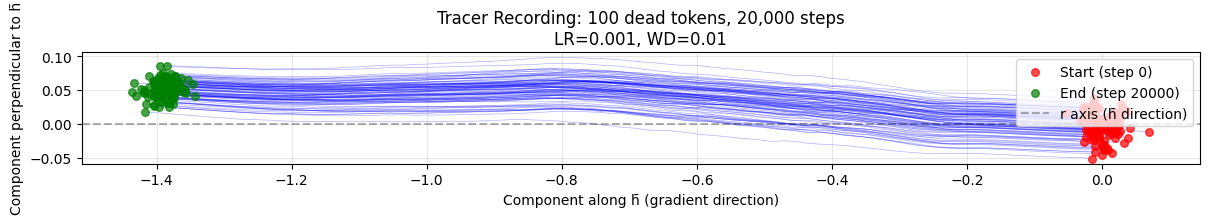

Saved: tracer_traces@72.png


In [22]:
# Plot traces - just like the toy!
fig, ax = plt.subplots(figsize=(12, 12))

# Draw traces
for i in range(NUM_TRACERS):
    trace = projections[:, i, :]  # (num_recordings, 2)
    ax.plot(trace[:, 0], trace[:, 1], 'b-', alpha=0.3, linewidth=0.5)

# Mark start (red) and end (green)
ax.scatter(projections[0, :, 0], projections[0, :, 1], 
           c='red', s=30, zorder=5, label=f'Start (step {steps[0]})', alpha=0.7)
ax.scatter(projections[-1, :, 0], projections[-1, :, 1], 
           c='green', s=30, zorder=5, label=f'End (step {steps[-1]})', alpha=0.7)

# Draw the r axis
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3, label='r axis (h̄ direction)')

ax.set_xlabel('Component along h̄ (gradient direction)')
ax.set_ylabel('Component perpendicular to h̄')
ax.set_title(f'Tracer Recording: {NUM_TRACERS} dead tokens, {TRAINING_STEPS:,} steps\n'
             f'LR={LEARNING_RATE}, WD={WEIGHT_DECAY}')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tracer_traces@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: tracer_traces@72.png")

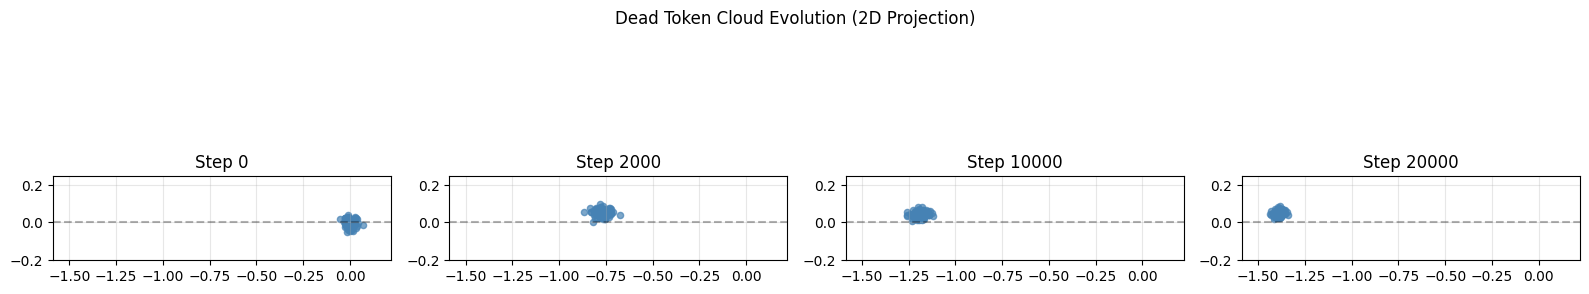

Saved: tracer_snapshots@200.png


In [23]:
# Snapshots at different times
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Pick snapshot indices
n = len(projections)
snapshot_indices = [0, n//10, n//2, n-1]

# Find global bounds
all_x = projections[:, :, 0].flatten()
all_y = projections[:, :, 1].flatten()
xmin, xmax = all_x.min(), all_x.max()
ymin, ymax = all_y.min(), all_y.max()
margin = 0.1 * max(xmax - xmin, ymax - ymin)

for ax, idx in zip(axes, snapshot_indices):
    ax.scatter(projections[idx, :, 0], projections[idx, :, 1], 
               c='steelblue', s=20, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)
    ax.set_aspect('equal')
    ax.set_title(f'Step {steps[idx]}')
    ax.grid(True, alpha=0.3)

fig.suptitle('Dead Token Cloud Evolution (2D Projection)', fontsize=12)
plt.tight_layout()
plt.savefig('tracer_snapshots@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: tracer_snapshots@200.png")

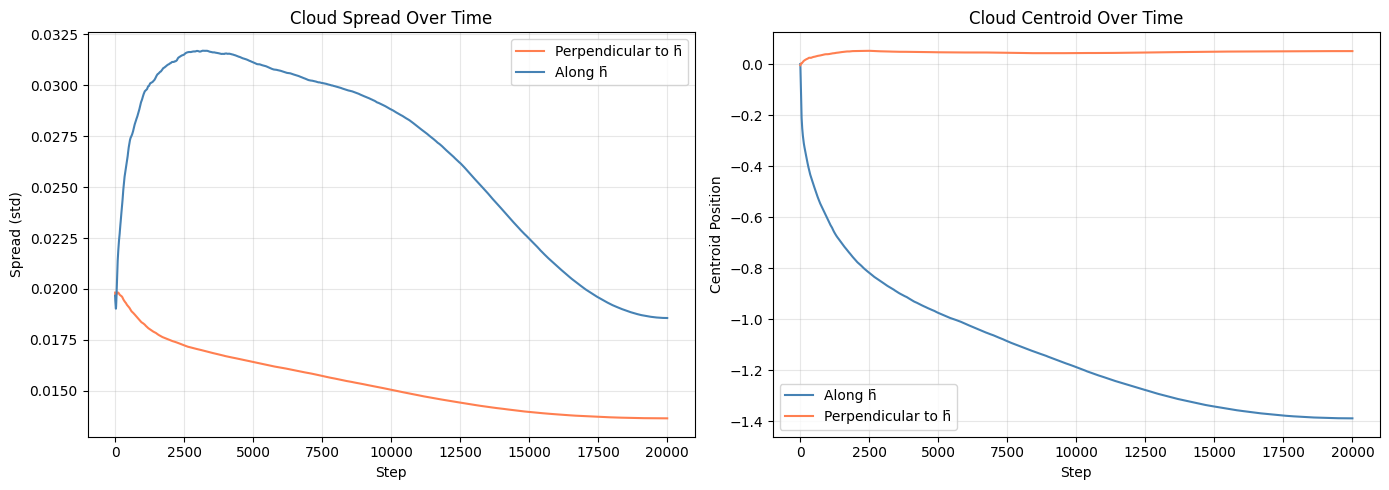


Initial perpendicular spread: 0.019822
Final perpendicular spread: 0.013648
Ratio: 0.6885

Initial centroid: (0.0015, -0.0032)
Final centroid: (-1.3878, 0.0520)


In [24]:
# Quantify: spread over time
along_r_spread = projections[:, :, 0].std(axis=1)  # std of x-coord at each timestep
perp_spread = projections[:, :, 1].std(axis=1)     # std of y-coord at each timestep

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread over time
axes[0].plot(steps, perp_spread, label='Perpendicular to h̄', color='coral')
axes[0].plot(steps, along_r_spread, label='Along h̄', color='steelblue')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Spread (std)')
axes[0].set_title('Cloud Spread Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Centroid position over time
centroid_x = projections[:, :, 0].mean(axis=1)
centroid_y = projections[:, :, 1].mean(axis=1)

axes[1].plot(steps, centroid_x, label='Along h̄', color='steelblue')
axes[1].plot(steps, centroid_y, label='Perpendicular to h̄', color='coral')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Centroid Position')
axes[1].set_title('Cloud Centroid Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tracer_metrics@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nInitial perpendicular spread: {perp_spread[0]:.6f}")
print(f"Final perpendicular spread: {perp_spread[-1]:.6f}")
print(f"Ratio: {perp_spread[-1]/perp_spread[0]:.4f}")
print(f"\nInitial centroid: ({centroid_x[0]:.4f}, {centroid_y[0]:.4f})")
print(f"Final centroid: ({centroid_x[-1]:.4f}, {centroid_y[-1]:.4f})")